<a href="https://colab.research.google.com/github/froge159/belief-project-sef/blob/main/phase3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
import random
import pandas as pd
# install bitsandbytes and restart

In [2]:
!pip install bitsandbytes

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dreaddit = pd.read_csv('/content/drive/MyDrive/SEF/Data/dreaddit.csv')

In [5]:
model_id = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_id, padding=True, truncation=True, model_max_length=512)
tokenizer.padding_side = "right"
tokenizer.truncation_side = "right"

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_config,
    dtype=torch.float16,
)
model.eval()

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [6]:
num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads
head_dim = model.config.hidden_size
device = "cuda" if torch.cuda.is_available() else "cpu"

# Extract Mean-Pooled Activations

In [7]:
def extract_mean_pooled_hidden(prompts, batch_size=8):
  all_pooled = []
  for i in range(0, len(prompts), batch_size):
    batch = prompts[i:i+batch_size]
    inputs = tokenizer(
        batch,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
      outputs = model(**inputs, output_hidden_states=True)

    hidden_states = outputs.hidden_states[1:]
    attention_mask = inputs["attention_mask"] # [bs, seq_len]
    mask = attention_mask.unsqueeze(-1)
    lengths = attention_mask.sum(dim=1).unsqueeze(-1)

    pooled_layers = []
    for hs in hidden_states:
        # hs: [bs, seq_len, hidden_dim]
        masked_sum = (hs * mask).sum(dim=1)     # [bs, hidden_dim]
        mean_pooled = masked_sum / lengths      # [bs, hidden_dim]
        pooled_layers.append(mean_pooled)

    # Stack layers: [bs, num_layers, hidden_dim]
    batch_pooled = torch.stack(pooled_layers, dim=1)
    all_pooled.append(batch_pooled.cpu())

  return torch.cat(all_pooled, dim=0)

In [8]:
mean_pooled = extract_mean_pooled_hidden(dreaddit['text'].tolist())

# Train Linear Probe

In [9]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import spearmanr

def train_linear_probe(mean_pooled, labels, n_splits=5, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    X_all = mean_pooled.detach().cpu().numpy()
    y_all = np.array(labels, dtype=float)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    results = []
    for layer_idx in range(X_all.shape[1]):
        X_layer = X_all[:, layer_idx, :]
        y_true_all = []
        y_pred_all = []
        for train_idx, test_idx in kf.split(X_layer):
            X_train, X_test = X_layer[train_idx], X_layer[test_idx]
            y_train, y_test = y_all[train_idx], y_all[test_idx]
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_true_all.append(y_test)
            y_pred_all.append(y_pred)
        y_true_all = np.concatenate(y_true_all)
        y_pred_all = np.concatenate(y_pred_all)
        if np.std(y_pred_all) == 0 or np.std(y_true_all) == 0:
            pearson = np.nan
            r2 = np.nan
            spearman_rho = np.nan
        else:
            pearson = np.corrcoef(y_true_all, y_pred_all)[0, 1]
            r2 = r2_score(y_true_all, y_pred_all)
            spearman_rho = spearmanr(y_true_all, y_pred_all)[0]
        mae = mean_absolute_error(y_true_all, y_pred_all)
        results.append({
            "layer": layer_idx,
            "pearson": pearson,
            "r2": r2,
            "spearman": spearman_rho,
            "mae": mae,
        })
    return pd.DataFrame(results)

test_results = train_linear_probe(mean_pooled, dreaddit["belief_score"].values)
display(test_results)

,layer,pearson,r2,spearman,mae
0,0,0.294924,-0.046432,0.294651,0.808335
1,1,0.394594,0.084850,0.380548,0.763027
2,2,0.456473,0.172888,0.461239,0.716538
3,3,0.467341,0.184666,0.469813,0.709292
4,4,0.441278,0.136108,0.420241,0.746191
5,5,0.460539,0.165036,0.430765,0.722046
6,6,0.436632,0.130051,0.405730,0.746099
7,7,0.449072,0.141468,0.422790,0.739531
8,8,0.419347,0.089564,0.394200,0.747505
9,9,0.461662,0.151029,0.443923,0.721870


# Validation Analyses

### Probe Validity Checks

In [10]:
# Shuffle labels and run probe
shuffled_labels = dreaddit["belief_score"].sample(frac=1, random_state=42).values
shuffled_results = train_linear_probe(mean_pooled, shuffled_labels)

# Compare early vs late layers for original and shuffled
num_layers = mean_pooled.shape[1]
early_layer = 0
late_layer = num_layers - 1

print("Original probe metrics (early vs late layer):")
print(test_results.loc[[early_layer, late_layer], ["layer", "pearson", "r2", "spearman", "mae"]])

print("\nShuffled probe metrics (early vs late layer):")
print(shuffled_results.loc[[early_layer, late_layer], ["layer", "pearson", "r2", "spearman", "mae"]])

Original probe metrics (early vs late layer):
    layer   pearson        r2  spearman       mae
0       0  0.294924 -0.046432  0.294651  0.808335
31     31  0.397831  0.000989  0.367420  0.788623

Shuffled probe metrics (early vs late layer):
    layer   pearson        r2  spearman       mae
0       0 -0.136588 -0.735865 -0.084309  1.019180
31     31 -0.047439 -0.587244 -0.075826  1.017817


### Group Level Comparison

In [11]:
# freeze the trained probe
# compute predicted belief strength for each text and calculate depressed vs control group means.
# then compare distributions, compute effect size, and run a simple statistical test.

from scipy.stats import ttest_ind

def group_level_probe(mean_pooled, labels, group_labels, layer_idx=0):
    """
    Use trained probe on a given layer to predict belief strength, compare group means, effect size, and t-test.
    Args:
        mean_pooled: torch.Tensor [n, num_layers, hidden_dim]
        labels: array-like, shape [n]
        group_labels: array-like, shape [n] (e.g., 'DEPRESSIVE' or 'CONTROL')
        layer_idx: int, layer to use for probe
    Returns:
        dict with group means, effect size, t-test results
    """
    # Train probe on all data for selected layer
    X = mean_pooled[:, layer_idx, :].detach().cpu().numpy()
    y = np.array(labels, dtype=float)
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    # Split by group
    group1 = y_pred[np.array(group_labels) == 'DEPRESSIVE']
    group2 = y_pred[np.array(group_labels) == 'CONTROL']
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)
    std1 = np.std(group1)
    std2 = np.std(group2)
    # Cohen's d
    pooled_std = np.sqrt(((len(group1)-1)*std1**2 + (len(group2)-1)*std2**2) / (len(group1)+len(group2)-2))
    cohens_d = (mean1 - mean2) / pooled_std
    # t-test
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
    return {
        'DEPRESSIVE_mean': mean1,
        'CONTROL_mean': mean2,
        "cohens_d": cohens_d,
        "t_stat": t_stat,
        "p_val": p_val,
    }

# Run group-level comparison for the last layer (best probe)
group_stats = group_level_probe(mean_pooled, dreaddit["belief_score"].values, dreaddit["category"].values, layer_idx=mean_pooled.shape[1]-1)
print("Group-level comparison (last layer):")
for k, v in group_stats.items():
    print(f"{k}: {v}")

Group-level comparison (last layer):
DEPRESSIVE_mean: 2.576171875
CONTROL_mean: 3.3671875
cohens_d: -0.8798828125
t_stat: -6.19222624294414
p_val: 3.360589352538623e-09


### Verify Similarity of Token-Length Distribution

Mann-Whitney U test: statistic=4652.5, p-value=0.39709361193256965


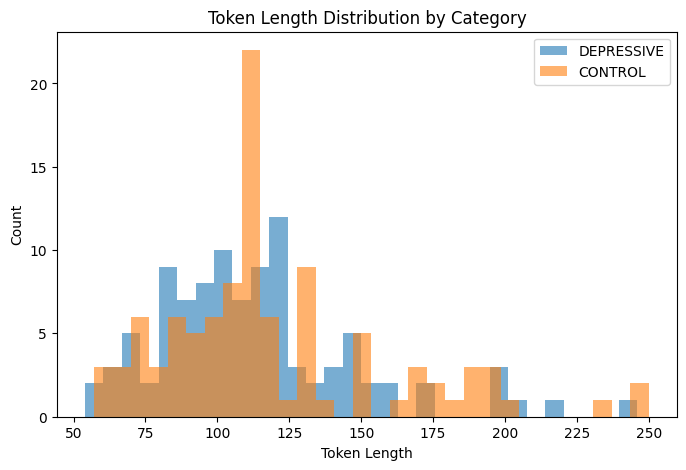

In [12]:
# addresses maybe longer posts look more hopeless type critiques
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Compute token lengths for each text
text_tokens = dreaddit['text'].apply(lambda x: len(tokenizer.tokenize(x)))
dreaddit['token_length'] = text_tokens

depressive_lengths = dreaddit.loc[dreaddit['category'] == 'DEPRESSIVE', 'token_length']
control_lengths = dreaddit.loc[dreaddit['category'] == 'CONTROL', 'token_length']

# Statistical test (Mann-Whitney U, nonparametric)
stat, p = mannwhitneyu(depressive_lengths, control_lengths, alternative='two-sided')
print(f"Mann-Whitney U test: statistic={stat}, p-value={p}")

# Plot distributions
plt.figure(figsize=(8,5))
plt.hist(depressive_lengths, bins=30, alpha=0.6, label='DEPRESSIVE')
plt.hist(control_lengths, bins=30, alpha=0.6, label='CONTROL')
plt.xlabel('Token Length')
plt.ylabel('Count')
plt.title('Token Length Distribution by Category')
plt.legend()
plt.show()

# Figures

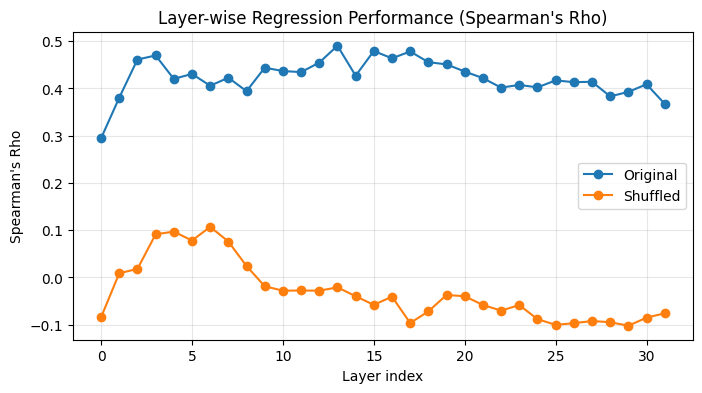

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Layer-wise Spearman's Rho for original vs shuffled labels
plt.figure(figsize=(8, 4))
plt.plot(test_results["layer"], test_results["spearman"], marker="o", label="Original")
plt.plot(shuffled_results["layer"], shuffled_results["spearman"], marker="o", label="Shuffled")
plt.xlabel("Layer index")
plt.ylabel("Spearman's Rho")
plt.title("Layer-wise Regression Performance (Spearman's Rho)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

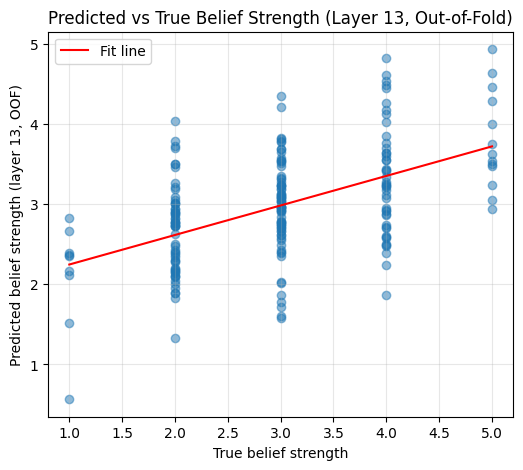

In [14]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Get out-of-fold predictions for a specific layer
layer_idx = 13
X = mean_pooled[:, layer_idx, :].detach().cpu().numpy()
y = np.array(dreaddit["belief_score"].values, dtype=float)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_oof = np.zeros_like(y)

for train_idx, test_idx in kf.split(X):
    model = LinearRegression()
    model.fit(X[train_idx], y[train_idx])
    y_pred_oof[test_idx] = model.predict(X[test_idx])

plt.figure(figsize=(6, 5))
plt.scatter(y, y_pred_oof, alpha=0.5)
m, b = np.polyfit(y, y_pred_oof, 1)
xs = np.linspace(y.min(), y.max(), 100)
plt.plot(xs, m * xs + b, color="red", label="Fit line")
plt.xlabel("True belief strength")
plt.ylabel("Predicted belief strength (layer 13, OOF)")
plt.title("Predicted vs True Belief Strength (Layer 13, Out-of-Fold)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

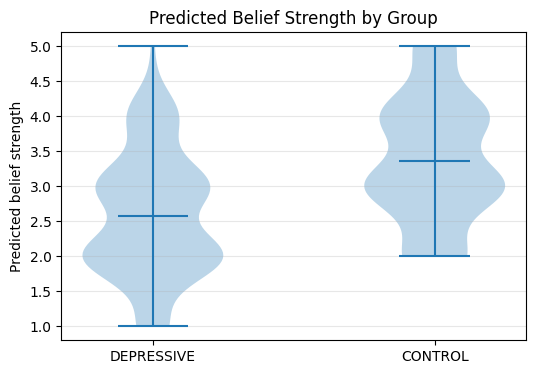

In [16]:
# Violin plot of predicted belief strength by group

# Re-calculate y_pred for the last layer (as used in group-level comparison)
layer_idx = mean_pooled.shape[1] - 1
X_for_pred = mean_pooled[:, layer_idx, :].detach().cpu().numpy()
y_true_for_pred = np.array(dreaddit["belief_score"].values, dtype=float)

model_for_pred = LinearRegression()
model_for_pred.fit(X_for_pred, y_true_for_pred)
y_pred = model_for_pred.predict(X_for_pred)

group_labels = np.array(dreaddit["category"].values)
pred_depressive = y_pred[group_labels == "DEPRESSIVE"]
pred_control = y_pred[group_labels == "CONTROL"]

plt.figure(figsize=(6, 4))
plt.violinplot([pred_depressive, pred_control], showmeans=True)
plt.xticks([1, 2], ["DEPRESSIVE", "CONTROL"])
plt.ylabel("Predicted belief strength")
plt.title("Predicted Belief Strength by Group")
plt.grid(axis="y", alpha=0.3)
plt.show()